# Exercise 7. Text Analytics in Social Media

## Text, Web and Social Media Analytics Lab

In this exercise, we will be using the [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset from Kaggle for Twitter sentiment analysis. We will first clean the data and then apply two well-known NLP packages for sentiment analysis. After that, we will train our own supervised and unsupervised sentiment analysis classifiers. We will follow the next steps: 

- Text Preprocessing
- Sentiment Analysis with NLP packages
- Supervised Sentiment Classifier
- Unsupervised Sentiment Classifier

We first install, import and download all the necessary libraries.

In [1]:
!pip install tweet-preprocessor

import nltk
import numpy as np
import pandas as pd
import inspect
import preprocessor
import matplotlib.pyplot as plt
from seaborn import countplot, distplot, heatmap
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessor.api import clean

nltk.download('vader_lexicon')
np.random.seed(37)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Part A: Text Preprocessing

We load the dataset and show the head to understand how the data looks like.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TWSM Analytics Lab/storage/Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We show a count plot to see the distribution of the sentiments, however, we can see that we have an unbalanced dataset where the negative sentiment is predominant by a large margin.

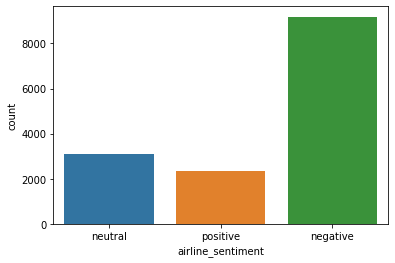

In [3]:
countplot(x='airline_sentiment', data=df)

We clean the tweets and append the results to the dataframe. We then show the original tweets and the clean tweets to check if the preprocessing was performed correctly.

In [4]:
df['prep'] = [clean(doc) for doc in df['text']]

df[['text', 'prep']].head()

,text,prep
0,@VirginAmerica What @dhepburn said.,What said.
1,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...
3,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent..."
4,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it


## Part B: Sentiment Analysis with NLP Packages

We use TextBlob to find the sentiment polarity of each tweet. This means that each tweet is assigned a number ranging from -1 to 1, where tweets close to -1 are negative, around 0 are neutral and close to 1 are positive. We print the basic statistics to confirm this, where we can see the value for the min and max values.

In [5]:
df['sentiment_tb'] = df['prep'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

df['sentiment_tb'].describe()

count    14640.000000
mean         0.053555
std          0.320756
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sentiment_tb, dtype: float64

We create a simple function that takes the polarity and assigns a sentiment between positive, negative or neutral. We apply this function on the polarity previously calculated and then show the dataset to check if everything worked correctly.

In [6]:
def label_sentiment(polarity):
  if polarity > 0.5:
    return 'positive'
  elif polarity < -0.5:
    return 'negative'
  else:
    return 'neutral'

df['sentiment_tb_desc'] = df['sentiment_tb'].apply(lambda polarity: label_sentiment(polarity))

df[['sentiment_tb', 'sentiment_tb_desc']]

,sentiment_tb,sentiment_tb_desc
0,0.000000,neutral
1,0.000000,neutral
2,-0.390625,neutral
3,0.006250,neutral
4,-0.350000,neutral
...,...,...
14635,0.000000,neutral
14636,-0.300000,neutral
14637,0.000000,neutral
14638,-0.125000,neutral


We print the classification report between the actual sentiment from the dataset and the sentiment we just calculated in the previous steps. We can see that the classifier performed poorly, even worse than randomly assigned. 

In [7]:
print(classification_report(df['airline_sentiment'], df['sentiment_tb_desc']))

              precision    recall  f1-score   support

    negative       0.95      0.06      0.11      9178
     neutral       0.22      0.94      0.36      3099
    positive       0.55      0.24      0.34      2363

    accuracy                           0.27     14640
   macro avg       0.57      0.41      0.27     14640
weighted avg       0.73      0.27      0.20     14640



We show three plots to see the distribution of the calculated polarities for each real sentiment category. Through these plots we can see why the classifier performed so badly; the calculated polarities do not really identify the actual sentiment of the tweet. It is more noticeable on the negative tweets, where we can see that the polarities range almost from -1 to +1. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

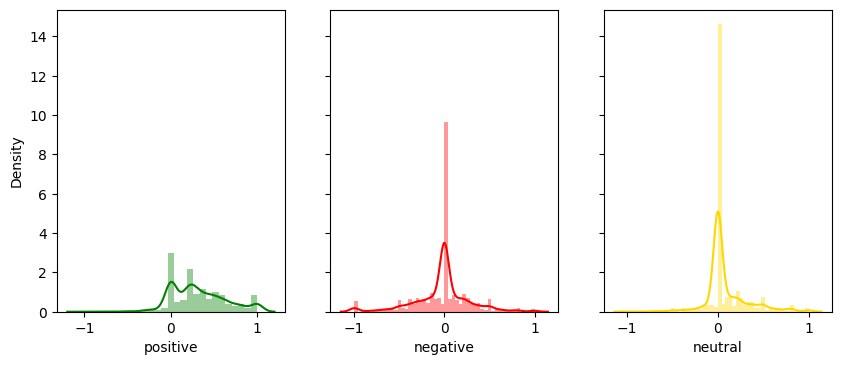

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)

distplot(df.loc[df.airline_sentiment == 'positive', 'sentiment_tb'], color='green', ax=axes[0], axlabel='positive')
distplot(df.loc[df.airline_sentiment == 'negative', 'sentiment_tb'], color='red', ax=axes[1], axlabel='negative')
distplot(df.loc[df.airline_sentiment == 'neutral', 'sentiment_tb'], color='gold', ax=axes[2], axlabel='neutral')

We use SentimentIntensityAnalyzer to calculate the sentiment polarities, which range from -1 to +1 like the previous calculations. We show the basic statistics of the calculation, where we can actually see a difference in the min and max values, as well as the lower and upper quartiles.

In [9]:
sid = SentimentIntensityAnalyzer()

df['sentiment_vd'] = df['prep'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])
df['sentiment_vd'].describe()

count    14640.000000
mean         0.051338
std          0.452522
min         -0.966800
25%         -0.296000
50%          0.000000
75%          0.421500
max          0.976000
Name: sentiment_vd, dtype: float64

Using the same simple function that we defined previously, we transform the polarity to the positive, negative and neutral labels. We then show the results to see if it worked correctly.

In [10]:
df['sentiment_vd_desc'] = df['sentiment_vd'].apply(lambda polarity: label_sentiment(polarity))

df[['sentiment_vd', 'sentiment_vd_desc']]

,sentiment_vd,sentiment_vd_desc
0,0.0000,neutral
1,0.0000,neutral
2,0.0000,neutral
3,-0.5984,negative
4,-0.5829,negative
...,...,...
14635,0.3612,neutral
14636,-0.7906,negative
14637,0.3182,neutral
14638,0.5027,positive


We print the classification report between the real sentiment and the one we just calculated in the previous step. We can see that the classifier did not perform very well, but it did outperform the previous classifier. We can also notice that it performed slightly better than random labeling.  

In [11]:
print(classification_report(df['airline_sentiment'], df['sentiment_vd_desc']))

              precision    recall  f1-score   support

    negative       0.95      0.21      0.34      9178
     neutral       0.26      0.81      0.39      3099
    positive       0.49      0.58      0.53      2363

    accuracy                           0.40     14640
   macro avg       0.56      0.53      0.42     14640
weighted avg       0.73      0.40      0.38     14640



We show the same three plots to see the distribution of the calculated polarities for each of the sentiment categories. We can see that also the polarities did not identify very well the sentiments, however, we do see that the density if less, so in general, there were less missclassifications. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

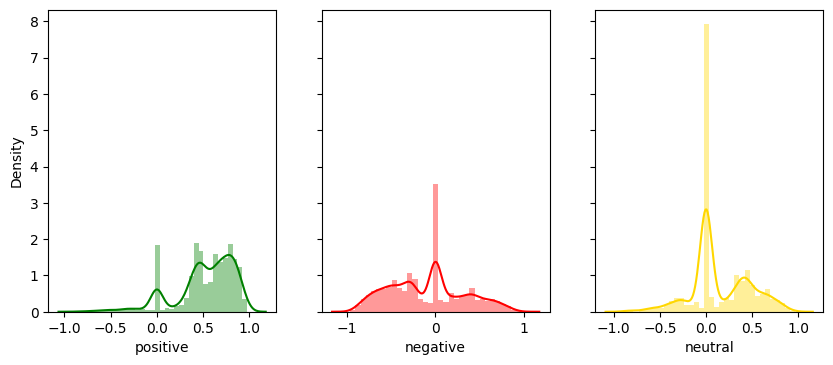

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)

distplot(df.loc[df.airline_sentiment == 'positive', 'sentiment_vd'], color='green', ax=axes[0], axlabel='positive')
distplot(df.loc[df.airline_sentiment == 'negative', 'sentiment_vd'], color='red', ax=axes[1], axlabel='negative')
distplot(df.loc[df.airline_sentiment == 'neutral', 'sentiment_vd'], color='gold', ax=axes[2], axlabel='neutral')

## Part C: Supervised Sentiment Classifier

We want to see if a supervised machine learning model would perform better than the previous classifiers. In order to do this, we define a TF-IDF Vectorizer object with 'max_df' of 0.99 and 'min_df' of 0.01, so it removes all words that appear in more than 99% and less than 1% of documents. We also tell the vectorizer to remove all English stopwords. We then fit and transform the vectorizer to our clean tweets.

In [13]:
vectorizer = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')
tf = vectorizer.fit_transform(df['prep'])

We split our transformed data into training and testing sets, using the airline sentiment as target variable. We also define the testing set size to be 20% of the whole size of the data. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tf, df['airline_sentiment'], test_size=0.2, random_state = 12)

We create a parameter grid with several different parameters, since we are going to do a grid search to find the optimal ones for our model. We decided to use a Random Forest classifier, so we will try different values for the minimum samples per leaf and the number of estimators. 

We then create a GridSearchCV object and pass it our Random Forest classifier, as well as the parameter grid. We also choose to use a 3-fold cross-validation. Finally, we train our Random Forest classifier with our training data.

In [15]:
param_grid = {'min_samples_leaf': [2, 3, 4, 5], 'n_estimators': [10, 50, 100, 200, 300, 1000]}

rf = RandomForestClassifier(random_state=42)

cv = GridSearchCV(rf, param_grid=param_grid, cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

We print the best parameters to check which performed the best. We then also use the best performing estimator to predict on our testing set and print the classification report to see how our model performed. It looks like it did quite well, at least much better than the previous classifiers.

In [16]:
print(cv.best_params_)
y_pred = cv.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

{'min_samples_leaf': 3, 'n_estimators': 300}
              precision    recall  f1-score   support

    negative       0.78      0.87      0.82      1876
     neutral       0.49      0.42      0.45       569
    positive       0.71      0.51      0.59       483

    accuracy                           0.72      2928
   macro avg       0.66      0.60      0.62      2928
weighted avg       0.71      0.72      0.71      2928



## Part D: Unsupervised Sentiment Classifier

We will now train an unsupervised machine learning model. We first start by getting the features identified by the TF-IDF vectorizer and then create a dataframe with the representation and the features as columns. We define a KMeans object for three clusters and max iteration of 200 until stopping. We then fit the KMeans model to our recently created dataframe.

In [17]:
words = vectorizer.get_feature_names()
tf_df = pd.DataFrame(tf.toarray(), columns=words)

kmeans = KMeans(n_clusters=3, max_iter=200)
kmeans.fit(tf_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We want to see if the clusters make sense to the sentiments. For this, we print the top 10 most representative words for each cluster and notice that cluster zero might be neutral, cluster one might be positive and cluster two might be negative.

In [18]:
common_words = kmeans.cluster_centers_.argsort()[:, -1: -11: -1]

for num, centroid in enumerate(common_words):
  print(str(num) + ':' + ','.join(words[word] for word in centroid))

0:thank,service,just,customer,help,flights,time,plane,amp,hold
1:flight,cancelled,flightled,delayed,late,hours,time,help,just,flighted
2:thanks,flight,just,great,service,help,got,response,guys,time


We create another simple function to label the clusters from what we found out in the previous step. If the cluster is zero, then it is neutral, if it is one, then it is positive and if it is two, then it is negative. We then apply this function to the labels from the KMeans model to get a dataframe with the sentiments. We show this dataframe to check that it makes sense.

In [21]:
def label_cluster(cluster):
  if cluster == 0:
    return 'neutral'
  elif cluster == 1:
    return 'negative'
  else:
    return 'positive'

cluster_sentiment = pd.DataFrame(kmeans.labels_, columns=['sentiment'])['sentiment'].apply(lambda sentiment: label_cluster(sentiment))
cluster_sentiment

0         neutral
1         neutral
2         neutral
3         neutral
4         neutral
           ...   
14635    negative
14636    negative
14637     neutral
14638    negative
14639    negative
Name: sentiment, Length: 14640, dtype: object

We then print the classification report to see how our unsupervised machine learning model performed by using the real sentiment and the cluster sentiment we just calculated. It looks like the model did not perform well either, but it did perform similarly to the SentimentIntensityAnalyzer. 

In [22]:
print(classification_report(df['airline_sentiment'], cluster_sentiment))

              precision    recall  f1-score   support

    negative       0.76      0.25      0.38      9178
     neutral       0.23      0.79      0.36      3099
    positive       0.58      0.24      0.34      2363

    accuracy                           0.36     14640
   macro avg       0.52      0.43      0.36     14640
weighted avg       0.62      0.36      0.37     14640

